In [21]:
# ---------------------------------------------------------
# 0. Imports
# ---------------------------------------------------------
import pandas as pd

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import MinTrace
from hierarchicalforecast.evaluation import evaluate
from utilsforecast.losses import rmse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 1. Carregar dados de treino e teste
#    (antes de 2024 = treino, 2024 = teste)
# ---------------------------------------------------------
train_path = "hts1_train_df.csv"  # ajuste para seu caminho real
test_path  = "hts1_test_df.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

# Converte data
for df in (train, test):
    df["date"] = pd.to_datetime(df["date"])

# Se você tiver um único CSV e quiser separar por data, seria algo como:
# data = pd.read_csv("todos_os_dados.csv")
# data["date"] = pd.to_datetime(data["date"])
# train = data[data["date"] < "2024-01-01"].copy()
# test  = data[data["date"] >= "2024-01-01"].copy()

# ---------------------------------------------------------
# 2. Preparar dados no formato esperado pelo HierarchicalForecast
#    - Ignoramos linhas onde continent == 'TOTAL' e deixamos o pacote
#      gerar o TOTAL pela agregação.
#    - Criamos uma coluna de nível superior ("World") constante.
#    - Renomeamos colunas para o padrão: ds (tempo), y (target)
#      e BaseModel (previsão do modelo base).
# ---------------------------------------------------------
def prepare_bottom_level(df: pd.DataFrame) -> pd.DataFrame:
    # Mantém apenas continentes (bottom level)
    df = df[df["continent"] != "TOTAL"].copy()

    df["World"] = "TOTAL"  # nível mais agregado

    df = df.rename(
        columns={
            "date": "ds",
            "continent": "Continent",
            "actual": "y",          # alvo
            "forecast": "BaseModel" # previsões base do seu modelo
        }
    )
    return df[["World", "Continent", "ds", "y", "BaseModel"]]

bottom_train = prepare_bottom_level(train)
bottom_test  = prepare_bottom_level(test)

# ---------------------------------------------------------
# 3. Construir a hierarquia (Total -> Continente) com aggregate
#    spec define os níveis:
#    - ["World"]                        -> série TOTAL
#    - ["World", "Continent"]          -> séries por continente
# ---------------------------------------------------------
hierarchy_levels = [
    ["World"],
    ["World", "Continent"]
]

# Treino: contém y (actual) + BaseModel (previsão 1-step-ahead/insample)
Y_train_df, S_df, tags = aggregate(
    df=bottom_train,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]  # agrega ambos
)

# Teste: contém y (valor observado no teste) + BaseModel (previsão out-of-sample)
Y_test_df, _, _ = aggregate(
    df=bottom_test,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]
)

# ---------------------------------------------------------
# 4. Separar dataframes no formato esperado pela reconciliação
#    - Y_df: dados "históricos" + previsões insample para estimar covariância
#            (aqui estamos usando treino, com colunas y e BaseModel)
#    - Y_hat_df: previsões base no período de teste (futuro)
#            (coluna BaseModel será reconciliada)
# ---------------------------------------------------------
Y_df = Y_train_df.copy()  # contém: unique_id, ds, y, BaseModel

# Y_hat_df: previsões para o horizonte futuro (teste).
# O HierarchicalForecast só precisa das colunas: unique_id, ds e modelos (BaseModel).
Y_hat_df = Y_test_df[["unique_id", "ds", "BaseModel"]].copy()

# ---------------------------------------------------------
# 5. Definir o reconciliador MinT (MinTrace com mint_shrink)
#    Isso é o equivalente ao MinT do FPP3.
# ---------------------------------------------------------
reconcilers = [
    MinTrace(method="mint_shrink"),  # MinT(Shrink),
    MinTrace(method="mint_cov"),
    MinTrace(method="ols")
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

# ---------------------------------------------------------
# 6. Rodar a reconciliação
#    - Y_hat_df: previsões base (teste)
#    - Y_df: dados com y e BaseModel no treino (para estimar matriz de covariância)
#    - S_df, tags: estrutura da hierarquia
# ---------------------------------------------------------
Y_rec_df = hrec.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=Y_df,
    S=S_df,
    tags=tags,
    intervals_method="bootstrap"
)

# O resultado terá colunas:
#   - "BaseModel" (previsão base incoerente)
#   - "BaseModel/MinTrace_method-mint_shrink" (previsão reconciliada MinT)

print(Y_rec_df.head(10))

# ---------------------------------------------------------
# 7. (Opcional) Juntar com os valores reais de teste e avaliar RMSE
# ---------------------------------------------------------
# Juntando previsões reconciliadas com os valores reais do período de teste
# (Y_test_df tem a coluna "y" com os valores observados nesse período)
Y_eval = Y_rec_df.merge(
    Y_test_df[["unique_id", "ds", "y"]],
    on=["unique_id", "ds"],
    how="left"
)

# Definir tags de avaliação por nível (Total e Continentes)
eval_tags = {
    "Total":     tags["World"],               # nível agregado (WORLD)
    "Continents": tags["World/Continent"],    # nível por continente
}

evaluation = evaluate(
    df=Y_eval,
    metrics=[rmse],
    tags=eval_tags,
    train_df=Y_df,  # opcional, útil p/ métricas tipo MASE
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)

#print(evaluation)


  unique_id         ds      BaseModel  BaseModel/MinTrace_method-mint_shrink  \
0     TOTAL 2024-01-01  141500.359237                          141500.359237   
1     TOTAL 2024-02-01  148564.770456                          148564.770456   
2     TOTAL 2024-03-01  140091.719848                          140091.719848   
3     TOTAL 2024-04-01  100946.212135                          100946.212135   
4     TOTAL 2024-05-01   84012.855983                           84012.855983   
5     TOTAL 2024-06-01   78338.005832                           78338.005832   
6     TOTAL 2024-07-01   90717.549668                           90717.549668   
7     TOTAL 2024-08-01  103066.077668                          103066.077668   
8     TOTAL 2024-09-01   95565.644110                           95565.644110   
9     TOTAL 2024-10-01  118832.114096                          118832.114096   

   BaseModel/MinTrace_method-mint_cov  BaseModel/MinTrace_method-ols  
0                       141500.359237           

C:\Users\Dog\AppData\Local\Temp\ipykernel_11772\4046658837.py:118: DeprecationWarning: The 'S' parameter is deprecated and will be removed in a future version. Please use 'S_df' instead.
  Y_rec_df = hrec.reconcile(


In [22]:
# ---------------------------------------------------------
# 1. Carregar dados de treino e teste
#    (antes de 2024 = treino, 2024 = teste)
# ---------------------------------------------------------
train_path = "hts2_train_df.csv"  # ajuste para seu caminho real
test_path  = "hts2_test_df.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

# Converte data
for df in (train, test):
    df["date"] = pd.to_datetime(df["date"])



bottom_train = prepare_bottom_level(train)
bottom_test  = prepare_bottom_level(test)

# ---------------------------------------------------------
# 3. Construir a hierarquia (Total -> Continente) com aggregate
#    spec define os níveis:
#    - ["World"]                        -> série TOTAL
#    - ["World", "Continent"]          -> séries por continente
# ---------------------------------------------------------
hierarchy_levels = [
    ["World"],
    ["World", "Continent"]
]

# Treino: contém y (actual) + BaseModel (previsão 1-step-ahead/insample)
Y_train_df_2, S_df_2, tags = aggregate(
    df=bottom_train,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]  # agrega ambos
)

# Teste: contém y (valor observado no teste) + BaseModel (previsão out-of-sample)
Y_test_df_2, _, _ = aggregate(
    df=bottom_test,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]
)

# ---------------------------------------------------------
# 4. Separar dataframes no formato esperado pela reconciliação
#    - Y_df: dados "históricos" + previsões insample para estimar covariância
#            (aqui estamos usando treino, com colunas y e BaseModel)
#    - Y_hat_df: previsões base no período de teste (futuro)
#            (coluna BaseModel será reconciliada)
# ---------------------------------------------------------
Y_df_2 = Y_train_df_2.copy()  # contém: unique_id, ds, y, BaseModel

# Y_hat_df: previsões para o horizonte futuro (teste).
# O HierarchicalForecast só precisa das colunas: unique_id, ds e modelos (BaseModel).
Y_hat_df_2 = Y_test_df_2[["unique_id", "ds", "BaseModel"]].copy()

# ---------------------------------------------------------
# 5. Definir o reconciliador MinT (MinTrace com mint_shrink)
#    Isso é o equivalente ao MinT do FPP3.
# ---------------------------------------------------------
reconcilers = [
    MinTrace(method="mint_shrink"),  # MinT(Shrink),
    MinTrace(method="mint_cov"),
    MinTrace(method="ols"),
    MinTrace(method="wls_var")
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

# ---------------------------------------------------------
# 6. Rodar a reconciliação
#    - Y_hat_df: previsões base (teste)
#    - Y_df: dados com y e BaseModel no treino (para estimar matriz de covariância)
#    - S_df, tags: estrutura da hierarquia
# ---------------------------------------------------------
Y_rec_df_2 = hrec.reconcile(
    Y_hat_df=Y_hat_df_2,
    Y_df=Y_df_2,
    S=S_df_2,
    tags=tags,
    #intervals_method="bootstrap"
)

# O resultado terá colunas:
#   - "BaseModel" (previsão base incoerente)
#   - "BaseModel/MinTrace_method-mint_shrink" (previsão reconciliada MinT)

print(Y_rec_df_2.head(10))

# ---------------------------------------------------------
# 7. (Opcional) Juntar com os valores reais de teste e avaliar RMSE
# ---------------------------------------------------------
# Juntando previsões reconciliadas com os valores reais do período de teste
# (Y_test_df tem a coluna "y" com os valores observados nesse período)
Y_eval_2 = Y_rec_df_2.merge(
    Y_test_df_2[["unique_id", "ds", "y"]],
    on=["unique_id", "ds"],
    how="left"
)

# Definir tags de avaliação por nível (Total e Continentes)
eval_tags = {
    "Total":     tags["World"],               # nível agregado (WORLD)
    "Continents": tags["World/Continent"],    # nível por continente
}

evaluation = evaluate(
    df=Y_eval_2,
    metrics=[rmse],
    tags=eval_tags,
    train_df=Y_df_2,  # opcional, útil p/ métricas tipo MASE
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)


C:\Users\Dog\AppData\Local\Temp\ipykernel_11772\2637869425.py:77: DeprecationWarning: The 'S' parameter is deprecated and will be removed in a future version. Please use 'S_df' instead.
  Y_rec_df_2 = hrec.reconcile(


  unique_id         ds      BaseModel  BaseModel/MinTrace_method-mint_shrink  \
0     TOTAL 2024-01-01  142400.526946                          142400.526946   
1     TOTAL 2024-02-01  139176.764673                          139176.764673   
2     TOTAL 2024-03-01  134101.221850                          134101.221850   
3     TOTAL 2024-04-01  100898.137083                          100898.137083   
4     TOTAL 2024-05-01   80824.933865                           80824.933865   
5     TOTAL 2024-06-01   84909.649577                           84909.649577   
6     TOTAL 2024-07-01  103343.917977                          103343.917977   
7     TOTAL 2024-08-01   95506.605254                           95506.605254   
8     TOTAL 2024-09-01   88748.314247                           88748.314247   
9     TOTAL 2024-10-01   98312.790617                           98312.790617   

   BaseModel/MinTrace_method-mint_cov  BaseModel/MinTrace_method-ols  \
0                       142400.526946          

### Verificando erros das previsões reconciliadas

### Xgboost

In [23]:
xgboost_df = pd.read_csv("xgboost_forecasts.csv")
xgboost_df = xgboost_df[xgboost_df["continent"] == "TOTAL (Agregado)"]
xgboost_df["continent"] = "TOTAL"
xgboost_df["model"] = "xgboost"

In [24]:
xgboost_df

,date,continent,actual,forecast,error,abs_error,pct_error,model
0,2024-01-01,TOTAL,163598.0,141374.900,22223.093750,22223.093750,13.583964,xgboost
1,2024-02-01,TOTAL,170305.0,136395.800,33909.203125,33909.203125,19.910868,xgboost
2,2024-03-01,TOTAL,157683.0,127224.700,30458.296875,30458.296875,19.316158,xgboost
3,2024-04-01,TOTAL,102172.0,87881.400,14290.601562,14290.601562,13.986808,xgboost
4,2024-05-01,TOTAL,84116.0,84481.280,-365.281250,365.281250,-0.434259,xgboost
5,2024-06-01,TOTAL,82402.0,81968.550,433.453125,433.453125,0.526023,xgboost
6,2024-07-01,TOTAL,108089.0,90105.766,17983.234375,17983.234375,16.637432,xgboost
7,2024-08-01,TOTAL,91504.0,106776.360,-15272.359375,15272.359375,-16.690374,xgboost
8,2024-09-01,TOTAL,116003.0,95834.260,20168.742188,20168.742188,17.386397,xgboost
9,2024-10-01,TOTAL,130985.0,124117.010,6867.992188,6867.992188,5.243343,xgboost


### HTS 1

In [25]:
hts1_df = Y_rec_df.loc[Y_rec_df["unique_id"] == "TOTAL"]
hts1_df["model"] = "HTS 1"
hts1_df = hts1_df.loc[:, ["ds", "BaseModel", "model"]]
hts1_df = hts1_df.rename(columns={"ds":"date", "BaseModel":"forecast"})
hts1_df=pd.concat([hts1_df, xgboost_df.loc[:,["actual"]]], axis=1)
hts1_df

C:\Users\Dog\AppData\Local\Temp\ipykernel_11772\2382689929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hts1_df["model"] = "HTS 1"


,date,forecast,model,actual
0,2024-01-01,141500.359237,HTS 1,163598.0
1,2024-02-01,148564.770456,HTS 1,170305.0
2,2024-03-01,140091.719848,HTS 1,157683.0
3,2024-04-01,100946.212135,HTS 1,102172.0
4,2024-05-01,84012.855983,HTS 1,84116.0
5,2024-06-01,78338.005832,HTS 1,82402.0
6,2024-07-01,90717.549668,HTS 1,108089.0
7,2024-08-01,103066.077668,HTS 1,91504.0
8,2024-09-01,95565.644110,HTS 1,116003.0
9,2024-10-01,118832.114096,HTS 1,130985.0


In [26]:
hts2_df = Y_rec_df_2.loc[Y_rec_df_2["unique_id"] == "TOTAL"]
hts2_df["model"] = "HTS 2"
hts2_df = hts2_df.loc[:, ["ds", "BaseModel", "model"]]
hts2_df = hts2_df.rename(columns={"ds":"date", "BaseModel":"forecast"})
hts2_df=pd.concat([hts2_df, xgboost_df.loc[:,["actual"]]], axis=1)
hts2_df

C:\Users\Dog\AppData\Local\Temp\ipykernel_11772\2931379353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hts2_df["model"] = "HTS 2"


,date,forecast,model,actual
0,2024-01-01,142400.526946,HTS 2,163598.0
1,2024-02-01,139176.764673,HTS 2,170305.0
2,2024-03-01,134101.221850,HTS 2,157683.0
3,2024-04-01,100898.137083,HTS 2,102172.0
4,2024-05-01,80824.933865,HTS 2,84116.0
5,2024-06-01,84909.649577,HTS 2,82402.0
6,2024-07-01,103343.917977,HTS 2,108089.0
7,2024-08-01,95506.605254,HTS 2,91504.0
8,2024-09-01,88748.314247,HTS 2,116003.0
9,2024-10-01,98312.790617,HTS 2,130985.0


### ets

In [27]:
ets_df = pd.read_csv("ets_forecasts_TEST.csv")
ets_df["model"] = "ETS"
ets_df = ets_df[ets_df["continent"] == "TOTAL"]
ets_df = ets_df.rename(columns={"ets_forecast":"forecast"})
ets_df

,date,continent,actual,forecast,error,abs_error,pct_error,ets_model,model_type,arima_model,model
84,2024-01-01,TOTAL,163598.0,125957.395989,37640.604011,37640.604011,23.007985,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS
85,2024-02-01,TOTAL,170305.0,122451.752243,47853.247757,47853.247757,28.098557,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS
86,2024-03-01,TOTAL,157683.0,114878.919469,42804.080531,42804.080531,27.145653,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS
87,2024-04-01,TOTAL,102172.0,84748.586954,17423.413046,17423.413046,17.053021,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS
88,2024-05-01,TOTAL,84116.0,69698.818464,14417.181536,14417.181536,17.139642,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS
89,2024-06-01,TOTAL,82402.0,88357.679724,-5955.679724,5955.679724,-7.227591,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS
90,2024-07-01,TOTAL,108089.0,95793.478446,12295.521554,12295.521554,11.375368,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS
91,2024-08-01,TOTAL,91504.0,91959.978968,-455.978968,455.978968,-0.498316,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS
92,2024-09-01,TOTAL,116003.0,79350.710887,36652.289113,36652.289113,31.595984,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS
93,2024-10-01,TOTAL,130985.0,89727.347376,41257.652624,41257.652624,31.497998,"ETS(M,N,M)",HYBRID,"(2, 1, 0, 0, 1, 0, 0)",ETS


### sarimax

In [28]:
# TESTE
# Previsoes do sarimax
# sarimax_df = pd.read_csv("00_sarimax_forecasts.csv")
# sarimax_df = sarimax_df.loc[sarimax_df["continent"] != "Oceania"]

# # Previsoes do sarimax oceania
# oceania_sarimax_df = pd.read_csv("oceania_sarimax_forecasts.csv")

# # Concatenando oceania e geral
# sarimax_df = pd.concat([sarimax_df, oceania_sarimax_df])
# sarimax_df = sarimax_df[sarimax_df["continent"] == "TOTAL"]
# sarimax_df["model"] = "SARIMAX"



# 11_sarimax_forecasts (filtra total, america_central_caribe, america_norte, asia)
# 01_sarimax_forecasts (filtra america_do_sul, europa)
# 00_sarimax_forecasts (filtra africa)

sarimax_11_df = pd.read_csv("11_sarimax_forecasts.csv")
sarimax_11_df = sarimax_11_df.loc[sarimax_11_df["continent"].isin(["TOTAL","America_Central_E_Caribe", "America_Do_Norte", "Asia"])]

sarimax_01_df = pd.read_csv("01_sarimax_forecasts.csv")
sarimax_01_df = sarimax_01_df.loc[sarimax_01_df["continent"].isin(["America_Do_Sul", "Europa"])]

sarimax_00_df = pd.read_csv("00_sarimax_forecasts.csv")
sarimax_00_df = sarimax_00_df.loc[sarimax_00_df["continent"].isin(["Africa"])]

# TESTE
# Previsoes do sarimax
# sarimax_df = pd.read_csv("00_sarimax_forecasts.csv")
sarimax_df = pd.concat([sarimax_11_df, sarimax_01_df, sarimax_00_df])
sarimax_df = sarimax_df.loc[sarimax_df["continent"] != "Oceania"]


# Previsoes do sarimax oceania
oceania_sarimax_df = pd.read_csv("oceania_sarimax_forecasts.csv")

# Concatenando oceania e geral
sarimax_df = pd.concat([sarimax_df, oceania_sarimax_df])

# Renomeando colunas
#sarimax_df=sarimax_df.rename(columns={"forecast": "sarimax_forecast"})
sarimax_df = sarimax_df[sarimax_df["continent"] == "TOTAL"]
sarimax_df["model"] = "SARIMAX"
sarimax_df

,date,continent,actual,forecast,error,model
0,2024-01-01,TOTAL,163598.0,132535.844552,31062.155448,SARIMAX
1,2024-02-01,TOTAL,170305.0,138608.676945,31696.323055,SARIMAX
2,2024-03-01,TOTAL,157683.0,133144.963534,24538.036466,SARIMAX
3,2024-04-01,TOTAL,102172.0,102560.878877,-388.878877,SARIMAX
4,2024-05-01,TOTAL,84116.0,79394.000350,4721.999650,SARIMAX
5,2024-06-01,TOTAL,82402.0,82091.571637,310.428363,SARIMAX
6,2024-07-01,TOTAL,108089.0,96243.703821,11845.296179,SARIMAX
7,2024-08-01,TOTAL,91504.0,93475.768188,-1971.768188,SARIMAX
8,2024-09-01,TOTAL,116003.0,88552.661350,27450.338650,SARIMAX
9,2024-10-01,TOTAL,130985.0,98511.732003,32473.267997,SARIMAX


In [29]:
sarimax_df

,date,continent,actual,forecast,error,model
0,2024-01-01,TOTAL,163598.0,132535.844552,31062.155448,SARIMAX
1,2024-02-01,TOTAL,170305.0,138608.676945,31696.323055,SARIMAX
2,2024-03-01,TOTAL,157683.0,133144.963534,24538.036466,SARIMAX
3,2024-04-01,TOTAL,102172.0,102560.878877,-388.878877,SARIMAX
4,2024-05-01,TOTAL,84116.0,79394.000350,4721.999650,SARIMAX
5,2024-06-01,TOTAL,82402.0,82091.571637,310.428363,SARIMAX
6,2024-07-01,TOTAL,108089.0,96243.703821,11845.296179,SARIMAX
7,2024-08-01,TOTAL,91504.0,93475.768188,-1971.768188,SARIMAX
8,2024-09-01,TOTAL,116003.0,88552.661350,27450.338650,SARIMAX
9,2024-10-01,TOTAL,130985.0,98511.732003,32473.267997,SARIMAX


In [30]:
actual_df = sarimax_df.loc[:, ["date", "continent", "actual", "model"]]
actual_df["forecast"] = actual_df["actual"]
actual_df["model"] = "actual"
actual_df

,date,continent,actual,model,forecast
0,2024-01-01,TOTAL,163598.0,actual,163598.0
1,2024-02-01,TOTAL,170305.0,actual,170305.0
2,2024-03-01,TOTAL,157683.0,actual,157683.0
3,2024-04-01,TOTAL,102172.0,actual,102172.0
4,2024-05-01,TOTAL,84116.0,actual,84116.0
5,2024-06-01,TOTAL,82402.0,actual,82402.0
6,2024-07-01,TOTAL,108089.0,actual,108089.0
7,2024-08-01,TOTAL,91504.0,actual,91504.0
8,2024-09-01,TOTAL,116003.0,actual,116003.0
9,2024-10-01,TOTAL,130985.0,actual,130985.0


In [31]:
def create_comparison_df(hts1_df, hts2_df,sar_df, xgb_df, ets_df, actual_df):
    hts1_df, hts2_df, sar_df, xgb_df, ets_df, actual_df = hts1_df.copy(), hts2_df.copy(), sar_df.copy(), xgb_df.copy(), ets_df.copy(), actual_df.copy()

    cols = ["date", "actual", "forecast", "model"]
    sar_df = sar_df.loc[:, cols]
    xgb_df = xgb_df.loc[:, cols]
    ets_df = ets_df.loc[:, cols]
    actual_df = actual_df.loc[:, cols]

    return  pd.concat([hts1_df, hts2_df, sar_df, xgb_df, ets_df, actual_df])

In [32]:
comparison_df = create_comparison_df(hts1_df = hts1_df, hts2_df=hts2_df, sar_df = sarimax_df, xgb_df = xgboost_df, ets_df = ets_df, actual_df=actual_df)
comparison_df.to_csv("comparison_df.csv", index=False)

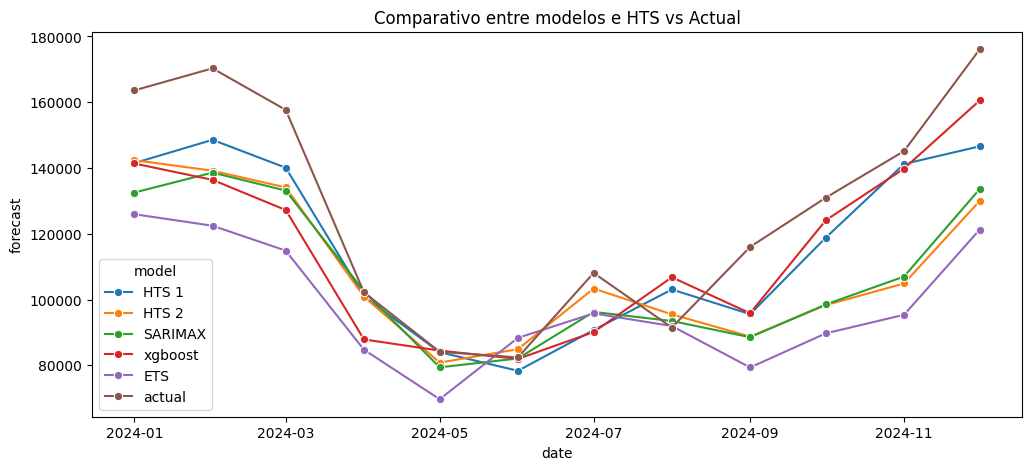

In [33]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comparison_df, x="date", y="forecast", hue="model", ax=ax, marker="o")
ax.set_title("Comparativo entre modelos e HTS vs Actual")
plt.show()

## Métricas de erro

In [34]:

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

df = comparison_df.copy()

metrics = []
for model, g in df.groupby('model'):
    y_true = g['actual']
    y_pred = g['forecast']
    metrics.append({
        'model': model,
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'MAPE (%)': mape(y_true, y_pred)
    })

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("hts_results.csv", index=False)


In [37]:
metrics_df

,model,RMSE,MAE,MAPE (%)
0,ETS,35079.436221,30113.453042,21.672070
1,HTS 1,16270.200275,13482.876467,9.896069
2,HTS 2,25149.399659,19836.169377,13.793152
3,SARIMAX,25508.990460,20592.730917,14.293002
4,actual,0.000000,0.000000,0.000000
5,xgboost,18387.481725,15238.287000,11.351640
